# imports

In [1]:
import os

os.environ["DJANGO_ALLOW_ASYNC_UNSAFE"] = "true"

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

mpl.pyplot.ion()
%matplotlib inline
import pickle

from qlp.mds import graph_tools as gt
from qlp.mds.qubo import get_mds_qubo
from qlp.mds.mds_qlpdb import QUBO_to_Ising, graph_summary

from qlp.tdse import TDSE, embed_qubo_example, convert_params, add_jchaos

from qlpdb.tdse.models import Tdse

import time

from scipy.sparse import dok_matrix

# Setup

## Set up ising model

Computes the corresponding Ising model parameters for the QUBO

**if embed is True:** 
    This embeds the QUBO into a chimera graph. Currently there is only an explicit result from G(2). I will in the future actually embed with DWave minorminer.

In [2]:
qubo = dok_matrix([[-0.25, 1], [0, -0.25]])
#qubo = dok_matrix([[-0.1, 0], [0, 0]])
print(qubo)
Jij_exact, hi_exact, c = QUBO_to_Ising(qubo.todense().tolist())
Jij = Jij_exact
hi = hi_exact
penalty = 0
qubo_constant = 0

graph_params = {"total_qubits": 2}

  (0, 0)	-0.25
  (0, 1)	1.0
  (1, 1)	-0.25


## Anneal specific parameters

Parameters which are related to converting physical unites to unitless units

* **annealing_time:** Annealing time as defined from s = [0, 1] in microseconds
* **normalized_time:** This is s. Set it to < 0 or > 1 if offset is used to allow for a complete annealing schedule. The total time in microseconds will increase accordingly.
* **energyscale:** Converts units from D-Wave parameters to unitless parameters (see eq. 65 in the notes)

In [3]:
annealing_time = 0.01
normalized_time = [0, 1]  # make larger range for complete offsets

# assume annealing_time unit in microsecond and energy unit in Ghz
def energyscaleconversion(annealing_time):
    return annealing_time * 1000.0 #* (2.0 * np.pi)


energyscale = energyscaleconversion(annealing_time)
ising_params = {
    "Jij": [list(row) for row in Jij],
    "hi": list(hi),
    "c": c,
    "Jij_exact": [list(row) for row in Jij_exact],
    "hi_exact": list(hi_exact),
    "energyscale": energyscale,
    "qubo_constant": qubo_constant,
    "penalty": penalty,
}
print(ising_params)

{'Jij': [[0.0, 0.25], [0.0, 0.0]], 'hi': [0.125, 0.125], 'c': 0.0, 'Jij_exact': [[0.0, 0.25], [0.0, 0.0]], 'hi_exact': [0.125, 0.125], 'energyscale': 10.0, 'qubo_constant': 0, 'penalty': 0}


## Anneal curve specific parameters

Parameters which specify how the anneal curve is realized:

* **offset:** This is a string argument to the fcn method of the class AnnealOffset in qlp.mds.mds_qlpdb. Define your own anneal offset routine here or call
an existing one. E-mail me if you need more explanation.
* **offset_min, offset_range:** Argument to AnnealOffset class. Specify offset boundaries and are set later in a loop.
* **anneal_curve:** The realized curve. Currently implemented are linear, logistic and d-wave.
* **fill_value:** If normalized_time is extended beyond (0, 1), this option decides whether to extrapolate the anneal schedule, or truncate it at the nearest value.

In [4]:
offset = "test"
anneal_curve = "dwave"
fill_value = "extrapolate"

## Parameters for numerical solve of ODE

Parameters to solve the ODE. See also `scipy.integrate.solve_ivp`.

In [5]:
solver_params = dict()
solver_params["method"] = "RK45"
solver_params["rtol"] = 1e-7
solver_params["atol"] = 1e-8

## System parameters

Parameters used to specify the initial conditions of the system:

* **pure_tdse:** This is a boolean (True / False) flag and runs the pure state solver.
* **mixed_tdse:** This boolean flag runs the mixed state solver.
* **temp:** This sets the temperature for the mixed state solver in kelvins.
* **initial_wavefunction:** For the pure state solver, the initial wavefunc- tion can be chosen to be the ground state of ∑σx (transverse) or H(0)(real). For the DWave anneal schedule, or when annealing offsets are used without extended annealing times, these two options are not the same. Can be "true" or "transverse".


In [6]:
initial_wavefunction = "transverse"

temp = 0.00001
temp_local = 0.00001
gamma = 0 #1/1 # 1/ns for full counting statistics
gamma_local = 0 #1/100 # for local decoherence

## Output parameters

Parameters used for visializing results:
* **degeneracy_tol:** This sets the numerical tolerance as to when an excited- state is labeled as degenerate to the ground state. This is important for graphs with degenerate ground states.
* **debug:** Write more output during computations.
* **save_result:** Store results to pickle files. 

In [7]:
degeneracy_tol = 2e-2
debug = True

# Run computations

In this section we run over different anneal time offsets

offset -0.1


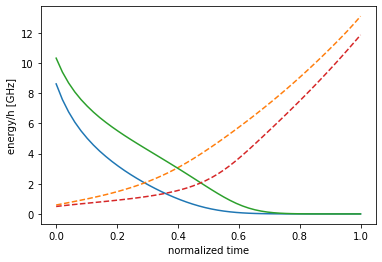

Ising ground state energy: -3.270953053219861
Ising ground state
2
00010
Ising ground state energy: -2.9612728584827996
Ising ground state
1
00001
abac->bc
entropy param 1 abac->bc
dE [ 0.         17.23218076 20.64296    37.87514076]
pr [1. 0. 0. 0.] total 1.0
Initial wavefunction: [0.25+0.j 0.25+0.j 0.25+0.j 0.25+0.j 0.25+0.j 0.25+0.j 0.25+0.j 0.25+0.j
 0.25+0.j 0.25+0.j 0.25+0.j 0.25+0.j 0.25+0.j 0.25+0.j 0.25+0.j 0.25+0.j]
Final Hamiltonian
[[ 6.23607055e+01 -2.64599900e-05  4.88191051e-05  0.00000000e+00]
 [-2.64599900e-05 -2.96127286e+01  0.00000000e+00  4.88191051e-05]
 [ 4.88191051e-05  0.00000000e+00 -3.27095305e+01 -2.64599900e-05]
 [ 0.00000000e+00  4.88191051e-05 -2.64599900e-05 -3.84464152e-02]]
Num. degenerate states @ s=1: 1
Mixed Final Prob: 0.7637690735244824
hi is [0.125, 0.125]
final state 10
offset 0


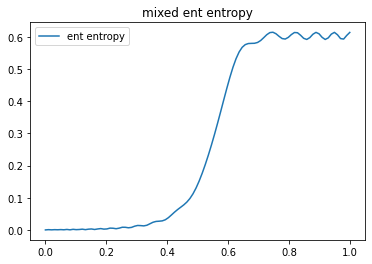

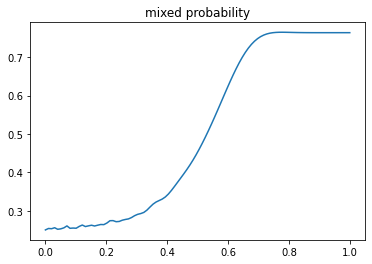

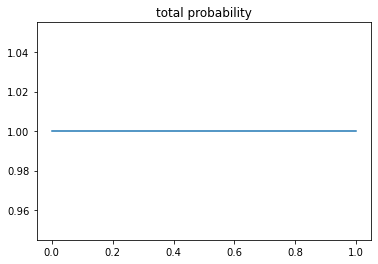

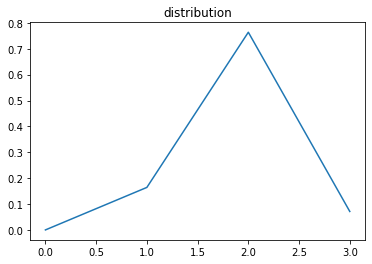

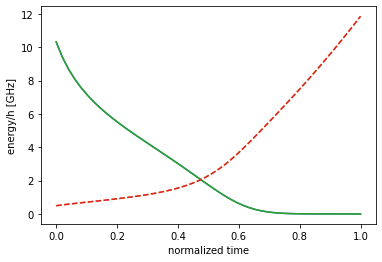

Ising ground state energy: -2.9651175
Ising ground state
1
00001
Ising ground state energy: -2.9651175
Ising ground state
2
00010
abac->bc
entropy param 1 abac->bc
dE [ 0.      20.64296 20.64296 41.28592]
pr [1. 0. 0. 0.] total 1.0
Initial wavefunction: [0.25+0.j 0.25+0.j 0.25+0.j 0.25+0.j 0.25+0.j 0.25+0.j 0.25+0.j 0.25+0.j
 0.25+0.j 0.25+0.j 0.25+0.j 0.25+0.j 0.25+0.j 0.25+0.j 0.25+0.j 0.25+0.j]
Final Hamiltonian
[[ 5.9302350e+01 -2.6459990e-05 -2.6459990e-05  0.0000000e+00]
 [-2.6459990e-05 -2.9651175e+01  0.0000000e+00 -2.6459990e-05]
 [-2.6459990e-05  0.0000000e+00 -2.9651175e+01 -2.6459990e-05]
 [ 0.0000000e+00 -2.6459990e-05 -2.6459990e-05  0.0000000e+00]]
Num. degenerate states @ s=1: 2
Mixed Final Prob: 0.8684778899173218
hi is [0.125, 0.125]
final state 10
offset 0.1


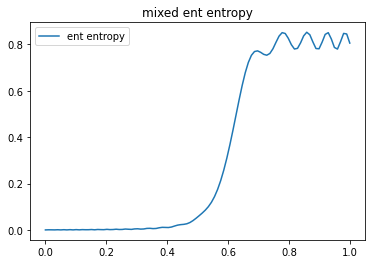

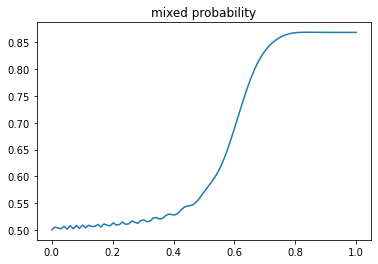

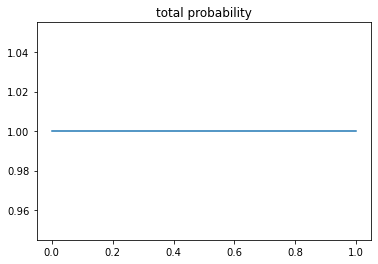

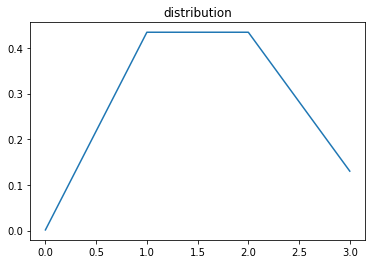

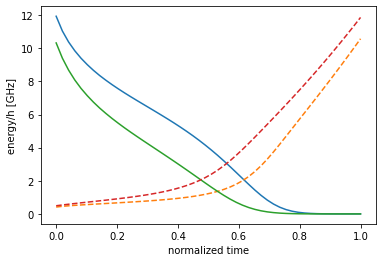

Ising ground state energy: -2.9605011093439115
Ising ground state
1
00001
Ising ground state energy: -2.638818303580421
Ising ground state
2
00010
acbd->acbd
entropy param 2 acbd->acbd
dE [ 0.         20.64296    23.86483458 44.50779458]
pr [1. 0. 0. 0.] total 1.0
Initial wavefunction: [0.25+0.j 0.25+0.j 0.25+0.j 0.25+0.j 0.25+0.j 0.25+0.j 0.25+0.j 0.25+0.j
 0.25+0.j 0.25+0.j 0.25+0.j 0.25+0.j 0.25+0.j 0.25+0.j 0.25+0.j 0.25+0.j]
Final Hamiltonian
[[ 5.60393580e+01 -2.64599900e-05 -3.78098578e-04  0.00000000e+00]
 [-2.64599900e-05 -2.96050111e+01  0.00000000e+00 -3.78098578e-04]
 [-3.78098578e-04  0.00000000e+00 -2.63881830e+01 -2.64599900e-05]
 [ 0.00000000e+00 -3.78098578e-04 -2.64599900e-05 -4.61639066e-02]]
Num. degenerate states @ s=1: 1
Mixed Final Prob: 0.6741618019349329
hi is [0.125, 0.125]
final state 01


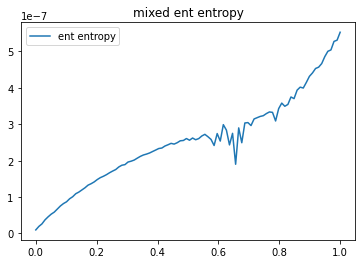

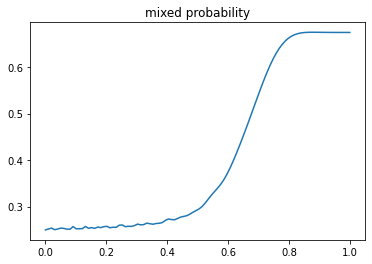

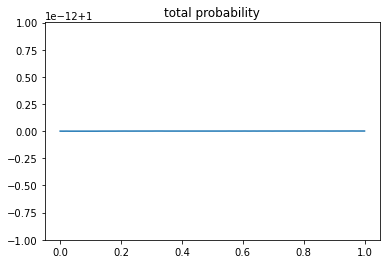

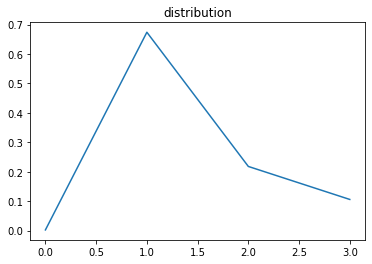

In [8]:
#%%timeit -n 1 -r 1

# brute force solving time-dependent schrodinger equation to simulate quantum annealing for small systems
result = dict()
offset_min_list = [-0.1, 0, 0.1]
Aoffset = 0

for offset_min in offset_min_list:
    print("offset", offset_min)
    offset_min = offset_min
    offset_range = 2 * abs(offset_min)

    offset_params = {
        "annealing_time": annealing_time,
        "normalized_time": normalized_time,
        "offset": offset,
        "hi_for_offset": [0, 0],
        "offset_min": offset_min,
        "offset_range": offset_range,
        "fill_value": fill_value,
        "anneal_curve": anneal_curve,
        "Aoffset": Aoffset
    }

    # instantiate ode solver
    tdse = TDSE(graph_params, ising_params, offset_params, solver_params)
    
    # plot anneal schedule
    tdse.AS.plot(normalized_time)
    
    val,vec=np.linalg.eigh(tdse.IsingH.todense())
    print('Ising ground state energy:',val[0])
    print('Ising ground state')
    #print(vec[:,0])
    I=int(np.argmax(vec[:,0]))
    print(I)
    print('{0:05b}'.format(I))
    print('Ising ground state energy:',val[1])
    print('Ising ground state')
    #print(vec[:,1])
    I=int(np.argmax(vec[:,1]))
    print(I)
    print('{0:05b}'.format(I))
    
    # get offset list to get partition for entanglement entropy
    nA, indicesA = tdse.find_partition()
    print("entropy param",nA,indicesA)
    reg = 1e-10
    entropy_params = {"nA": nA, "indicesA": indicesA, "reg": reg}
    
    ############################################################
    ###### code block for thermal mixed state simultation ######
    ############################################################
    wave_params = dict()
    wave_params["type"] = "mixed"
    wave_params["temp"] = temp
    wave_params["temp_local"] = temp_local
    wave_params["gamma"] = gamma
    wave_params["gamma_local"] = gamma_local
    wave_params["initial_wavefunction"] = initial_wavefunction

    # initial density matrix
    rho = tdse.init_densitymatrix(temp, temp_local, initial_wavefunction, debug=debug)
    rhodim=int(np.sqrt(len(rho)))
    tdse.gamma=gamma
    tdse.gamma_local=gamma_local
    print("Initial wavefunction:", rho)
    
    ######################
    ##### solve TDSE #####
    ######################
    sol_densitymatrix = tdse.solve_mixed(rho)

    
    ###########################
    ##### compile results #####
    ###########################
    # print final Hamiltonian with offset
    print("Final Hamiltonian")
    print(tdse.annealingH(1).todense().real)
    
    # overlap with Ising ground state
    gs_idx, Isingenergy, Isingeigv = tdse.ground_state_degeneracy(
        tdse.IsingH_exact, degeneracy_tol, debug=debug
    )
    project = sum(
        [
            np.kron(Isingeigv[:, idx], np.conj(Isingeigv[:, idx]))
            for idx in gs_idx
        ]
    )
    prob = np.asarray(
        [
            np.absolute((np.dot(np.conj(project), sol_densitymatrix.y[:, i])))
            for i in range(sol_densitymatrix.t.size)
        ]
    )
    totalprob = np.asarray(
        [
            np.absolute((np.trace(sol_densitymatrix.y[:, i].reshape((rhodim,rhodim)))))
            for i in range(sol_densitymatrix.t.size)
        ]
    )

    # calculate entanglement entropy
    sol = sol_densitymatrix
    time = sol_densitymatrix.t
    entropy = np.asarray(
        [
            tdse.ent_entropy(sol.y[:, i], **entropy_params)
            for i in range(sol.t.size)
        ]
    ).real
    # plot entropy
    plt.figure("mixed entropy")
    plt.plot(time, entropy)
    plt.legend(["ent entropy"])
    plt.title("mixed ent entropy")

    # plot overlap with Ising g.s.
    plt.figure("mixed prob")
    plt.plot(time, prob)
    plt.title("mixed probability")
    print(f"Mixed Final Prob: {prob[-1]}")
    
    # plot total probability.
    plt.figure("total prob")
    plt.plot(time, totalprob)
    plt.title("total probability")

    # check decoherence
    print("hi is",tdse.ising["hi"])
    finalstate=np.argmax(np.diagonal(sol_densitymatrix.y[:, -1].reshape((rhodim,rhodim))).real)
    print("final state",('{0:0'+str(len(tdse.ising["hi"]))+'b}').format(finalstate))
    
    # check distribution
    plt.figure("distribution")
    plt.plot(np.linspace(0,rhodim-1,rhodim), np.diagonal(sol_densitymatrix.y[:, -1].reshape((rhodim,rhodim))).real)
    plt.title("distribution")